In [143]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.init as init
import random 
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import time

In [138]:
class VanillaRNN(nn.Module):
    def __init__(self, num_input, num_hidden, num_output):
        super(VanillaRNN, self).__init__()
        
        self.num_hidden = num_hidden
        
        self.i2h = nn.Linear(num_input+num_hidden, num_hidden)
        self.h2o = nn.Linear(num_hidden, num_output)
        self.tanh = nn.Tanh()
        
        init.xavier_normal_(self.i2h.weight)
        init.xavier_normal_(self.h2o.weight)
    
    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        
        # Input+Hidden to Hidden
        a = self.i2h(input_combined)
        
        # Activation
        hidden = self.tanh(a)
        
        # Hidden to Output
        output = self.h2o(hidden)
        
        return output, hidden
    
    # Helper to init hidden state
    def initHidden(self):
        return torch.zeros(1, self.num_hidden)        

### Load data

In [106]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Vietnamese.txt', 'data/names/English.txt', 'data/names/Russian.txt', 'data/names/Dutch.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Spanish.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Arabic.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Scottish.txt', 'data/names/Greek.txt', 'data/names/Korean.txt', 'data/names/Portuguese.txt', 'data/names/Polish.txt']


In [107]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def nameToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(device=None):
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    if device:
        category_tensor = category_tensor.to(computing_device)
        line_tensor = line_tensor.to(computing_device)
    return category, line, category_tensor, line_tensor

print(nameToTensor('Jones').size())

torch.Size([5, 1, 57])


In [126]:
def get_computing_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
LEARNING_RATE = 0.0005
INPUT = n_letters
HIDDEN = 256
OUTPUT = len(all_categories)
computing_device = get_computing_device()

n_iters =  600_000
print_every = 5000

rnn = VanillaRNN(INPUT, HIDDEN, OUTPUT)
rnn.to(computing_device)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)

In [139]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

def train_one_complete_sample(name_tensor, label_tensor, optimizer=None):
    hidden = rnn.initHidden().to(computing_device)
    
    if optimizer:
        optimizer.zero_grad()
    else:
        rnn.zero_grad()    
    
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
        
    loss = criterion(output, label_tensor)
    loss.backward()
    
    if optimizer:
        optimizer.step()
    else:    
        for p in rnn.parameters():
            p.data.add_(-LEARNING_RATE, p.grad.data)
        
    return output, loss.item()    

def train():
    current_loss = 0
    all_losses = []
    for i_iter in range(1, n_iters + 1):
        
        category, line, category_tensor, line_tensor = randomTrainingExample(computing_device)
        output, loss = train_one_complete_sample(line_tensor, category_tensor)
        
        current_loss += loss
        all_losses.append(loss)

        if i_iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (i_iter, i_iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    return all_losses

In [130]:
train()

5000 0% (0m 12s) 2.7653 Beckert / English ✗ (German)
10000 1% (0m 24s) 2.1897 Kurogane / Japanese ✓
15000 2% (0m 37s) 2.8397 Snaaijer / Spanish ✗ (Dutch)
20000 3% (0m 49s) 3.2827 Godo / Vietnamese ✗ (Japanese)
25000 4% (1m 0s) 1.8382 Ton / Korean ✗ (Vietnamese)
30000 5% (1m 14s) 2.1660 Rorris / Portuguese ✗ (Greek)
35000 5% (1m 26s) 2.2073 Kaluza / Arabic ✗ (Polish)
40000 6% (1m 38s) 2.8361 Maneates / Dutch ✗ (Greek)
45000 7% (1m 51s) 1.2660 Bui / Chinese ✗ (Vietnamese)
50000 8% (2m 3s) 0.9558 Hruska / Czech ✓
55000 9% (2m 16s) 1.6083 Ermacora / Spanish ✗ (Italian)
60000 10% (2m 25s) 1.0111 Caivano / Italian ✓
65000 10% (2m 37s) 0.5264 Millar / Scottish ✓
70000 11% (2m 49s) 0.2080 Kawaguchi / Japanese ✓
75000 12% (2m 57s) 0.2134 Roncalli / Italian ✓
80000 13% (3m 10s) 2.7091 Tomes / Portuguese ✗ (Czech)
85000 14% (3m 22s) 2.9592 Kennedy / Dutch ✗ (Scottish)
90000 15% (3m 34s) 0.8936 Traverso / Italian ✓
95000 15% (3m 47s) 1.6669 Young / Scottish ✓
100000 16% (3m 59s) 2.5984 Qureshi / I

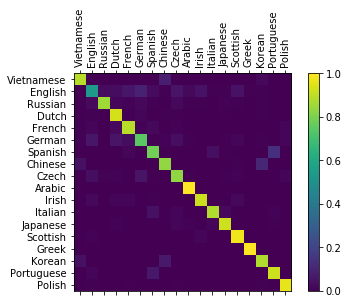

In [144]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden().to(computing_device)

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample(computing_device)
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()